In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow" 
import tensorflow
import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import random
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sklearn
from sklearn import model_selection
from tensorflow.keras.optimizers import SGD, Adam, Adamax

In [2]:
X = pd.read_csv('newvariables.csv')

ds = X.sample(frac=1)

ds.to_csv('Aug22.csv')

In [3]:
#read data
X = pd.read_csv("Aug22.csv")

outcome_vars = X.columns[10:]
outcome_vars

Index([' collision_system'], dtype='object')

In [4]:
X.drop(X.columns[[0]], axis = 1, inplace = True) 

Y_train= X[outcome_vars]
X_train = X.drop(list(outcome_vars), axis=1)
print(X_train.head())
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape

   jet_1_pt   jet_2_pt   jet_1_e   jet_2_e   delta_phi   delta_eta  \
0  0.577525   0.413136  0.512187  0.353438    1.122580    0.872070   
1  0.747881   0.788361  0.874375  0.895625    0.953237    0.469788   
2  0.902754   0.449164  0.851875  0.435000    1.112160   -0.008057   
3  0.902754   0.449164  0.851875  0.435000    1.112160   -0.008057   
4  0.414591   0.321239  0.470937  0.395000    0.912694    0.656738   

    centrality   multiplicity_1   multiplicity_2  
0        1.990             0.16             0.08  
1        0.525             0.52             0.32  
2        0.765             0.21             0.18  
3        0.765             0.21             0.18  
4        1.990             0.20             0.11  


(497, 9)

In [5]:
intermediate_dim = 6
latent_dim = 2
       
original_dim = X_train.shape[1]

inputs = Input(shape=(original_dim,))
hidden = Dense(intermediate_dim, activation='relu')(inputs)
hidden2 = Dense(intermediate_dim, activation='relu')(hidden)
z_mean = Dense(latent_dim, activation='linear')(hidden2)
z_sigma = Dense(latent_dim,activation='linear')(hidden2)
    
def sample_z(args):
    z_mean, z_sigma = args
    eps = K.random_normal(shape=(K.shape(inputs)[0],latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_sigma / 2) * eps 

z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_sigma])
encoder = Model(inputs, z_mean)
encoder.load_weights("encoder_relu_deep6.h5")

In [6]:
 def sample_z(args):
        z_mean, z_sigma = args
        eps = K.random_normal(shape=(K.shape(inputs)[0],latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_sigma / 2) * eps 

z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_sigma])
encoder = Model(inputs, z_mean)
    
    # The Decoder
decoder_hidden = Dense(intermediate_dim, activation='relu') 
decoder_mean = Dense(original_dim, activation='linear')  
decoder_sigma = Dense(original_dim, activation='linear')


hidden_output = decoder_hidden(z)
output_decoded_mean = decoder_mean(hidden_output) 
output_decoded_sigma = decoder_sigma(hidden_output) 

decoder = Model(inputs, output_decoded_mean)
    
    
    
predictor_input = Input(shape=(latent_dim,))

predictor_decoded = decoder_hidden(predictor_input)
predictor_output_mean = decoder_mean(predictor_decoded)
predictor_output_sigma = decoder_sigma(predictor_decoded)

predictor = Model(predictor_input, predictor_output_mean)
predictor.load_weights("predictor_relu_deep6.h5")

In [7]:
n_examples = 100

old_x = X_train[:n_examples]
zvals = encoder.predict(old_x)
#print(old_x)
#print(zvals)

In [8]:
old_x_new = tensorflow.convert_to_tensor(old_x, np.float32)

with tensorflow.GradientTape() as tape:
    tape.watch(old_x_new)
    prediction = encoder.call(old_x_new)[:, 0]
grads = tape.gradient(prediction, old_x_new)
#print(grads)

In [9]:

old_y= grads.numpy()

In [10]:
x1 = old_x[:,1 ]
y1 = old_y[:,1 ]
x0 = old_x[:,0 ]
y0 = old_y[:,0 ]
x2 = old_x[:,2 ]
y2 = old_y[:,2 ]
x3 = old_x[:,3 ]
y3 = old_y[:,3 ]
x4 = old_x[:,4 ]
y4 = old_y[:,4 ]
x5 = old_x[:,5 ]
y5 = old_y[:,5 ]
x6 = old_x[:,6 ]
y6 = old_y[:,6 ]
x7 = old_x[:,7 ]
y7 = old_y[:, 7]
x8 = old_x[:,8]
y8 = old_y[:,8 ]


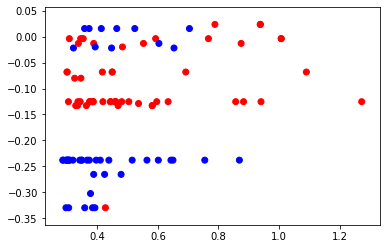

In [11]:
Y_train_color=[]
for i in range(n_examples):
    if Y_train[i]==1:
        Y_train_color.append("red")
    else:
        Y_train_color.append("blue")
plt.scatter(x1, y1, c=Y_train_color)
plt.show()

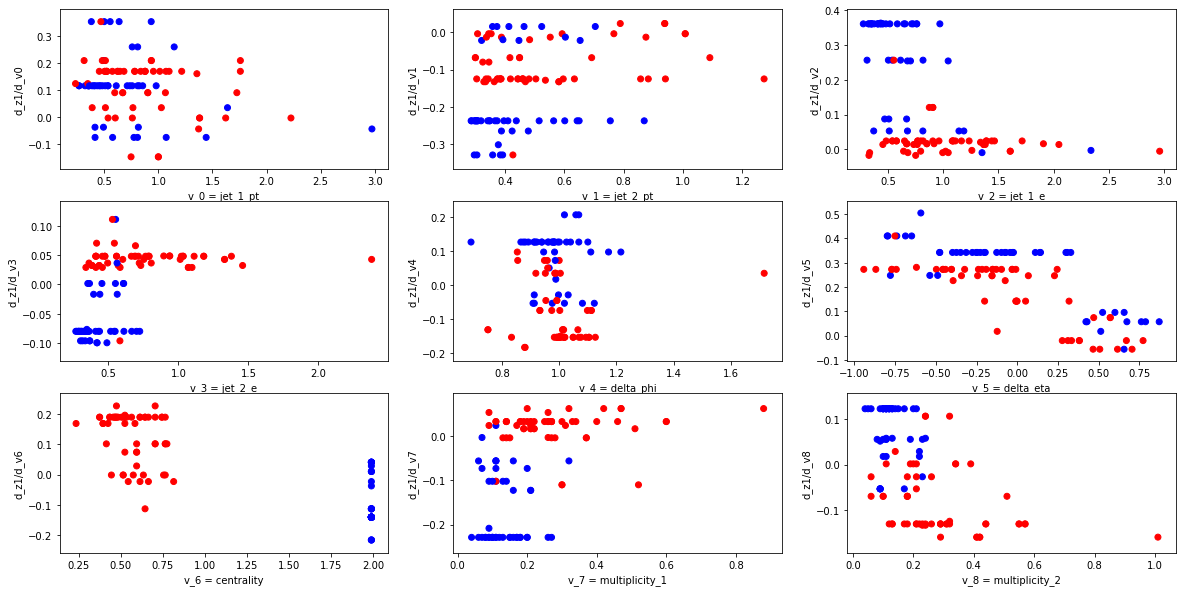

In [13]:

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,3,1)
ax1 =plt.scatter(x0, y0, c=Y_train_color)
plt.xlabel('v_0 = jet_1_pt')
plt.ylabel('d_z1/d_v0')

ax2 = fig.add_subplot(3,3,2)
ax2 =plt.scatter(x1, y1, c=Y_train_color)
plt.xlabel('v_1 = jet_2_pt')
plt.ylabel('d_z1/d_v1')

ax3 = fig.add_subplot(3,3,3)
ax3 = plt.scatter(x2, y2, c=Y_train_color)
plt.xlabel('v_2 = jet_1_e')
plt.ylabel('d_z1/d_v2')

ax4 = fig.add_subplot(3,3,4)
ax4 = plt.scatter(x3, y3, c=Y_train_color)
plt.xlabel('v_3 = jet_2_e')
plt.ylabel('d_z1/d_v3')

ax5 = fig.add_subplot(3,3,5)
ax5 =plt.scatter(x4, y4, c=Y_train_color)
plt.xlabel('v_4 = delta_phi')
plt.ylabel('d_z1/d_v4')

ax6 = fig.add_subplot(3,3,6)
ax6 =plt.scatter(x5, y5, c=Y_train_color)
plt.xlabel('v_5 = delta_eta')
plt.ylabel('d_z1/d_v5')

ax7 = fig.add_subplot(3,3,7)
ax7 = plt.scatter(x6, y6, c=Y_train_color)
plt.xlabel('v_6 = centrality')
plt.ylabel('d_z1/d_v6')

ax8 = fig.add_subplot(3,3,8)
ax8 = plt.scatter(x7, y7, c=Y_train_color)
plt.xlabel('v_7 = multiplicity_1')
plt.ylabel('d_z1/d_v7')

ax9 = fig.add_subplot(3,3,9)
ax9 = plt.scatter(x8, y8, c=Y_train_color)
plt.xlabel('v_8 = multiplicity_2')
plt.ylabel('d_z1/d_v8')

plt.show()       

In [87]:
points = np.random.rand(n_examples, 2)
for i in range(n_examples):
    points[i][0]= old_x[:,0][i]
    points[i][1]= old_x[:,1][i]
print(points)

[[0.563492 0.347222]
 [0.901788 0.435267]
 [0.581928 0.401119]
 [0.623854 0.379514]
 [0.788578 0.47654 ]
 [0.454813 0.418348]
 [0.504702 0.395067]
 [0.597171 0.416679]
 [0.935403 0.581442]
 [1.44207  0.704176]
 [0.363225 0.319272]
 [0.354557 0.366229]
 [0.515498 0.447329]
 [0.342947 0.288122]
 [1.24535  0.429658]
 [0.412595 0.335148]
 [0.322522 0.304828]
 [0.41523  0.372923]
 [0.704292 0.456217]
 [0.378595 0.347352]
 [0.412595 0.335148]
 [0.742933 0.779072]
 [0.369438 0.308936]
 [0.482173 0.328715]
 [0.878832 0.940433]
 [0.816657 0.299055]
 [0.706974 0.509868]
 [0.535637 0.345043]
 [1.0136   0.633823]
 [0.9513   0.291608]
 [0.344772 0.311936]
 [2.74921  0.970479]
 [0.639561 0.494539]
 [0.486034 0.464035]
 [1.11608  0.713776]
 [0.799158 0.69375 ]
 [0.704292 0.456217]
 [0.901788 0.435267]
 [0.680047 0.453633]
 [0.848505 0.446338]
 [0.314023 0.363779]
 [0.389399 0.356372]
 [1.02805  0.874802]
 [0.294014 0.415587]
 [0.347815 0.345911]
 [0.759342 0.561566]
 [0.457637 0.299516]
 [0.294445 0.

In [88]:
grid_x, grid_y = np.mgrid[0:2:100j, 0:2:100j]
values = zvals[:,1 ]

In [89]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

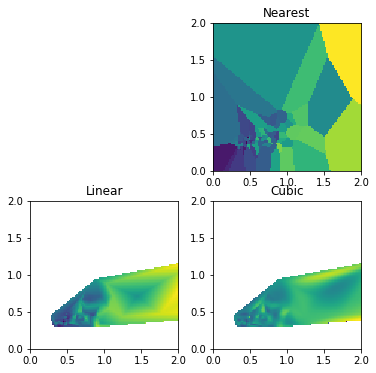

In [90]:
#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
#plt.plot(points[:,0], points[:,1], 'k.', ms=1)
#plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,2,0,2), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,2,0,2), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,2,0,2), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [12]:
names = ['jet_1_pt', 'jet_2_pt','jet_1_e', ' jet_2_e',  'delta_phi', 'delta_eta', 'centrality', 'multiplicity_1', 'multiplicity_2']

#min_z = -1
#max_z = 2
#skip = 1
n_z=2

latent_vars = {}
latent_var_spectra = {}

for i in range(n_z):  
    latent_name = "z" + str(i)
    latent_vars[latent_name] = {}
    latent_var_spectra[latent_name] = np.zeros(len(names))
    layer = latent_vars[latent_name]
    for z in [0,0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]: 
        zvals[:, i] = z
        new_x = predictor.predict(zvals)  
        new_z = np.ones(n_examples) * z
        if "x" in layer:
            layer["x"] = np.concatenate((layer["x"], new_x))
        else:
            layer["x"] = new_x
        if "z" in layer:
            layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
        else:
            layer["z"] = new_z
            
    # Take the correlation between the latent variable and all other original data variables,
    for j, real_varname in enumerate(names):
        latent_var_spectra[latent_name][j] = np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x'][:, j])[0, 1]
        

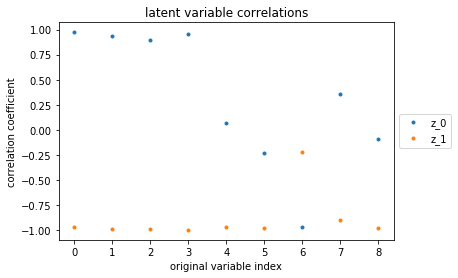

In [13]:

for i in range(n_z): 
    plt.plot(latent_var_spectra["z" + str(i)], '.', label="z_" + str(i))
plt.xlabel('original variable index')
plt.ylabel('correlation coefficient')
plt.title('latent variable correlations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [95]:
xnew = []
for i in range(n_examples):
    xnew.append(old_x[:,0][i])
print(xnew)
ynew = []
for i in range(n_examples):
    ynew.append(old_x[:,1][i])
print(ynew)
znew = []
for i in range(n_examples):
    znew.append(zvals[:,1][i])
print(znew)

[0.563492, 0.901788, 0.581928, 0.623854, 0.788578, 0.454813, 0.5047020000000001, 0.597171, 0.935403, 1.44207, 0.363225, 0.354557, 0.515498, 0.342947, 1.24535, 0.412595, 0.322522, 0.41523, 0.704292, 0.378595, 0.412595, 0.742933, 0.369438, 0.482173, 0.878832, 0.816657, 0.706974, 0.535637, 1.0136, 0.9513, 0.344772, 2.74921, 0.6395609999999999, 0.486034, 1.11608, 0.799158, 0.704292, 0.901788, 0.6800470000000001, 0.848505, 0.314023, 0.389399, 1.02805, 0.294014, 0.347815, 0.759342, 0.457637, 0.294445, 0.808183, 0.407346, 0.954379, 0.63071, 0.495337, 0.8089189999999999, 0.8377020000000001, 0.742933, 0.720312, 0.429338, 0.595433, 0.889595, 0.710646, 0.902754, 0.486181, 0.6774020000000001, 0.475031, 0.529433, 0.327741, 0.436217, 0.697012, 2.32838, 0.472757, 0.513999, 0.269252, 1.18738, 1.02805, 0.660409, 0.855268, 0.50776, 0.626467, 0.495317, 0.39224, 0.479372, 0.442762, 5.00161, 0.377005, 0.71392, 0.936675, 1.75845, 0.758763, 0.344697, 0.492805, 0.508352, 0.437954, 0.534246, 0.711497, 0.749992

ValueError: not enough values to unpack (expected 2, got 1)

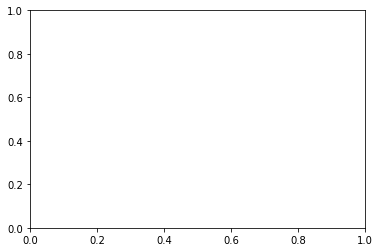

In [96]:
x_edges, y_edges = np.mgrid[-1:1:21j, -1:1:21j]

plt.figure()
lims = dict(cmap='RdBu_r', vmin=-0.25, vmax=0.25)
plt.pcolormesh(x_edges, y_edges, znew, shading='flat', **lims)
plt.colorbar()
plt.title("Sparsely sampled function.")
plt.show()

In [97]:
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data

edges = np.linspace(-1.0, 1.0, 101)
centers = edges[:-1] + np.diff(edges[:2])[0] / 2.
XI, YI = np.meshgrid(centers, centers)

# use RBF
rbf = Rbf(xnew, ynew, znew, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
plt.subplot(1, 1, 1)
X_edges, Y_edges = np.meshgrid(edges, edges)
lims = dict(cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.pcolormesh(X_edges, Y_edges, ZI, shading='flat', **lims)
plt.scatter(x, y, 100, z, edgecolor='w', lw=0.1, **lims)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.colorbar()


LinAlgError: Matrix is singular.

In [8]:
squarex= np.zeros((n_examples, 18))
for i in range(n_examples):
    for j in range(18):
        if j<9:
            squarex[i][j]= old_x[i][j]
        else:
            quant = (old_x[i][9-j])**2
            squarex[i][j]= quant

In [9]:
squarex= np.array(squarex)
print(old_x)

[[ 4.67256e-01  3.34827e-01  4.09375e-01  3.19063e-01  9.73608e-01
   1.40625e-01  1.99000e+00  5.00000e-02  1.00000e-01]
 [ 3.27447e-01  2.89607e-01  4.28438e-01  4.13750e-01  1.18478e+00
   3.79272e-01  1.99000e+00  1.10000e-01  5.00000e-02]
 [ 2.56262e-01  2.86590e-01  3.37500e-01  2.97812e-01  1.04063e+00
  -7.61414e-02  1.99000e+00  1.20000e-01  1.40000e-01]
 [ 3.09618e-01  3.02573e-01  3.04844e-01  2.91094e-01  1.01419e+00
   7.32056e-01  1.99000e+00  8.00000e-02  1.20000e-01]
 [ 8.48505e-01  4.46338e-01  7.23125e-01  4.43125e-01  7.76935e-01
   1.11237e-01  1.99000e+00  7.00000e-02  8.00000e-02]
 [ 5.05564e-01  4.58792e-01  6.86875e-01  6.88750e-01  1.09545e+00
   6.38916e-01  5.55000e-01  2.80000e-01  3.20000e-01]
 [ 6.70849e-01  3.00220e-01  6.69375e-01  3.83750e-01  9.32400e-01
  -1.95312e-03  7.05000e-01  2.20000e-01  1.00000e-01]
 [ 4.62092e-01  3.40194e-01  4.52500e-01  3.29688e-01  9.44296e-01
  -5.33081e-01  1.99000e+00  1.50000e-01  5.00000e-02]
 [ 5.32853e-01  3.08684e

In [10]:
output=[[i] for i in zvals[:, 1]]
output_y = np.array(output)
output_y.shape

(100, 1)

In [11]:
# First we load the entire CSV file into an m x 3
import tensorflow as tf
# We extract all rows and the first 2 columns into X_data
# Then we flip it
X_data = squarex.transpose()

# We extract all rows and the last column into y_data
# Then we flip it
y_data = output_y.transpose()

# And make a convenient variable to remember the number of input columns
n = 18

# Define data placeholders
x = tf.placeholder(tf.float32, shape=(n, None))
y = tf.placeholder(tf.float32, shape=(1, None))



In [12]:
# Define trainable variables
A = tf.get_variable("A", shape=(1, n))
b = tf.get_variable("b", shape=())

# Define model output
y_predicted = tf.matmul(A, x) + b

# Define the loss function
L = tf.reduce_sum((y_predicted - y)**2)

# Define optimizer object
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(L)

# Create a session and initialize variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Main optimization loop
arr=[]
for t in range(2000):
    _, current_loss, current_A, current_b = session.run([optimizer, L, A, b], feed_dict={
        x: X_data,
        y: y_data
    })
    arr+= [current_A]
    if(t==1999):
        print("t = %g, loss = %g, A = %s, b = %g" % (t, current_loss, str(current_A), current_b))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
t = 1999, loss = 0.177764, A = [[ 0.2204461  -0.17854632  0.22356033  0.13602701  0.5141464   0.0519418
   0.04412149  0.13831626 -0.19632012  0.03428444  0.46969277 -0.6265465
  -0.10023585 -0.04439176 -0.07573421 -0.10441387 -0.11988034  0.00411676]], b = -0.378095


In [11]:
y = [i[0][9] for i in arr]
plt.plot([i[0][1] for i in arr])
plt.show()

IndexError: index 9 is out of bounds for axis 0 with size 9

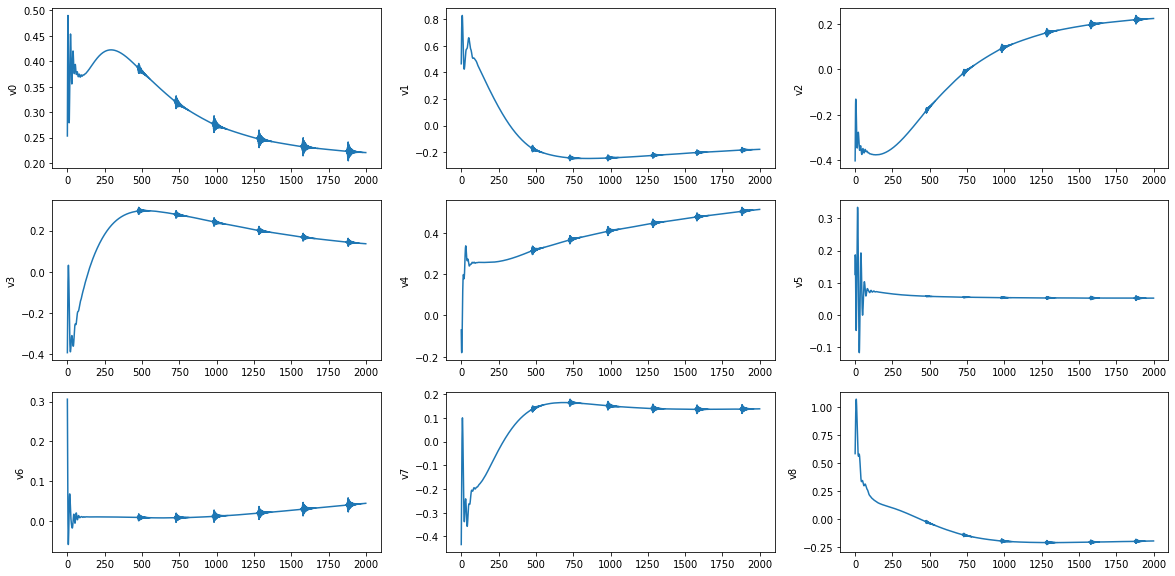

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,3,1)
ax1 =plt.plot([i[0][0] for i in arr])
plt.ylabel('v0')

ax2 = fig.add_subplot(3,3,2)
ax2 =plt.plot([i[0][1] for i in arr])
plt.ylabel('v1')

ax3 = fig.add_subplot(3,3,3)
ax3 = plt.plot([i[0][2] for i in arr])
plt.ylabel('v2')

ax4 = fig.add_subplot(3,3,4)
ax4 = plt.plot([i[0][3] for i in arr])
plt.ylabel('v3')

ax5 = fig.add_subplot(3,3,5)
ax5 = plt.plot([i[0][4] for i in arr])
plt.ylabel('v4')

ax6 = fig.add_subplot(3,3,6)
ax6 = plt.plot([i[0][5] for i in arr])
plt.ylabel('v5')

ax7 = fig.add_subplot(3,3,7)
ax7 = plt.plot([i[0][6] for i in arr])
plt.ylabel('v6')

ax8 = fig.add_subplot(3,3,8)
ax8 = plt.plot([i[0][7] for i in arr])
plt.ylabel('v7')

ax9 = fig.add_subplot(3,3,9)
ax9 = plt.plot([i[0][8] for i in arr])
plt.ylabel('v8')

plt.show()

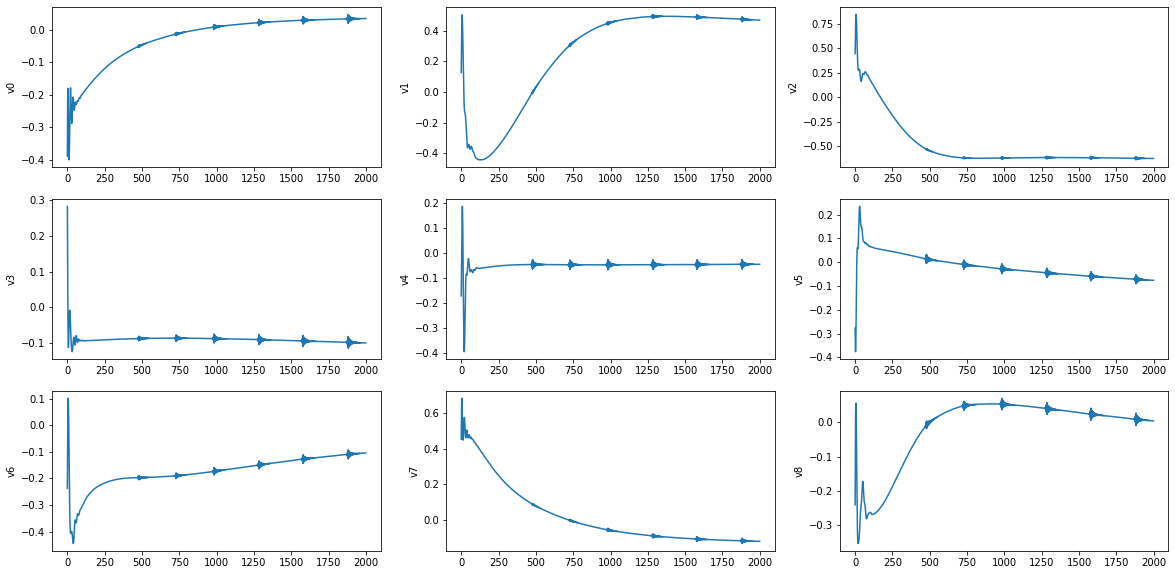

In [14]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,3,1)
ax1 =plt.plot([i[0][9] for i in arr])
plt.ylabel('v0')

ax2 = fig.add_subplot(3,3,2)
ax2 =plt.plot([i[0][10] for i in arr])
plt.ylabel('v1')

ax3 = fig.add_subplot(3,3,3)
ax3 = plt.plot([i[0][11] for i in arr])
plt.ylabel('v2')

ax4 = fig.add_subplot(3,3,4)
ax4 = plt.plot([i[0][12] for i in arr])
plt.ylabel('v3')

ax5 = fig.add_subplot(3,3,5)
ax5 = plt.plot([i[0][13] for i in arr])
plt.ylabel('v4')

ax6 = fig.add_subplot(3,3,6)
ax6 = plt.plot([i[0][14] for i in arr])
plt.ylabel('v5')

ax7 = fig.add_subplot(3,3,7)
ax7 = plt.plot([i[0][15] for i in arr])
plt.ylabel('v6')

ax8 = fig.add_subplot(3,3,8)
ax8 = plt.plot([i[0][16] for i in arr])
plt.ylabel('v7')

ax9 = fig.add_subplot(3,3,9)
ax9 = plt.plot([i[0][17] for i in arr])
plt.ylabel('v8')

plt.show()

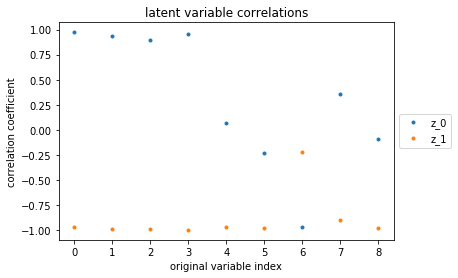

In [14]:
for i in range(n_z): 
    plt.plot(latent_var_spectra["z" + str(i)], '.', label="z_" + str(i))
plt.xlabel('original variable index')
plt.ylabel('correlation coefficient')
plt.title('latent variable correlations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()